<a href="https://colab.research.google.com/github/kfahn22/Colab_notebooks/blob/main/photo_maker_demo_2_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PhotoMaker

[PhotoMaker](https://github.com/TencentARC/PhotoMaker) was introduced in [PhotoMaker: Customizing Realistic Human Photos via Stacked ID Embedding](https://arxiv.org/abs/2312.04461) by Li, et. al. 

The notebook from adapted from [here](https://github.com/TencentARC/PhotoMaker/blob/main/photomaker_demo.ipynb). 

It runs OK on a T4, but relatively fast on a \A100

In [1]:
!pip install diffusers
!pip install accelerate
!pip install git+https://github.com/TencentARC/PhotoMaker.git
!git clone https://github.com/TencentARC/PhotoMaker.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.1 MB/s eta 0:00:00
  Cloning https://github.com/TencentARC/PhotoMaker.git to /tmp/pip-req-build-2ov5_ugt
  Running command git clone --filter=blob:none --quiet https://github.com/TencentARC/PhotoMaker.git /tmp/pip-req-build-2ov5_ugt
  Resolved https://github.com/TencentARC/PhotoMaker.git to commit fece4f358e8be570a3e4156405fe4513d82e1878
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for photomaker: filename=photomaker-0.1.0-py3-none-any.whl size=17349 sha256=d22cc35b1862c4ee006ecae94ba75821b5550d426f15469ca13bcc2e2d9aaa66
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ggtzabw/wheels/3f/2f/4e/83e335096e6226398168e21ce9c3c1dd2c2b57777191ad0e82
Successfully built photomaker
Cloning into 'PhotoMaker'...
remote: Enumerating objects: 215, done.


In [2]:
%cd PhotoMaker/

/content/PhotoMaker


In [3]:
import torch
import numpy as np
import random
import os
from PIL import Image

from diffusers.utils import load_image
from diffusers import EulerDiscreteScheduler, DDIMScheduler
from huggingface_hub import hf_hub_download

from photomaker import PhotoMakerStableDiffusionXLPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
# gloal variable and function
def image_grid(imgs, rows, cols, size_after_resize):
    assert len(imgs) == rows*cols

    w, h = size_after_resize, size_after_resize

    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        img = img.resize((w,h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

base_model_path = 'SG161222/RealVisXL_V3.0'
device = "cuda"
save_path = "./outputs"

LoRA

https://huggingface.co/docs/diffusers/en/tutorials/using_peft_for_inference

https://huggingface.co/docs/peft/main/en/conceptual_guides/lora

In [5]:
from huggingface_hub import hf_hub_download

photomaker_ckpt = hf_hub_download(repo_id="TencentARC/PhotoMaker", filename="photomaker-v1.bin", repo_type="model")

pipe = PhotoMakerStableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16, #edited to change from bfloat16
    use_safetensors=True,
    variant="fp16",
).to(device)
# Added these 
pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()

pipe.load_photomaker_adapter(
    os.path.dirname(photomaker_ckpt),
    subfolder="",
    weight_name=os.path.basename(photomaker_ckpt),
    trigger_word="img"
)
pipe.id_encoder.to(device)


#pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
#pipe.fuse_lora()

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# pipe.set_adapters(["photomaker"], adapter_weights=[1.0])
pipe.fuse_lora()

photomaker-v1.bin:   0%|          | 0.00/934M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading PhotoMaker components [1] id_encoder from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/3602d02ba7cc99ce8886e24063ed10e4f2510c84]...
Loading PhotoMaker components [2] lora_weights from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker/snapshots/3602d02ba7cc99ce8886e24063ed10e4f2510c84]


/usr/local/lib/python3.10/dist-packages/diffusers/loaders/lora.py:1078: FutureWarning: `fuse_text_encoder_lora` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("fuse_text_encoder_lora", "0.27", LORA_DEPRECATION_MESSAGE)


Need to add input image

In [6]:
import os
examples = "/content/examples"
os.makedirs(examples, exist_ok=True)

Input ID images:


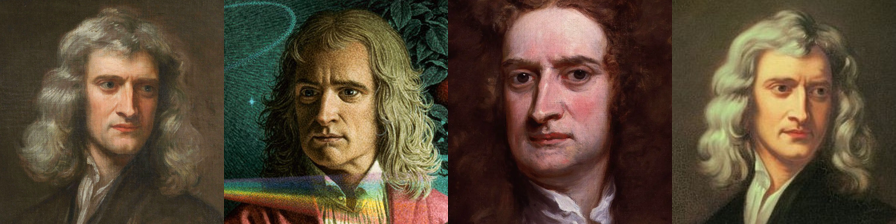

In [13]:
# define and show the input ID images
#input_folder_name = examples
input_folder_name = './examples/newton_man'
image_basename_list = os.listdir(input_folder_name)
image_path_list = sorted([os.path.join(input_folder_name, basename) for basename in image_basename_list])

input_id_images = []
for image_path in image_path_list:
    input_id_images.append(load_image(image_path))

input_grid = image_grid(input_id_images, 1, 4, size_after_resize=224)
print("Input ID images:")
input_grid

In [14]:
## Note that the trigger word `img` must follow the class word for personalization
prompt = "sci-fi, closeup portrait photo of a man img wearing the sunglasses in Iron man suit, face, slim body, high quality, film grain"
negative_prompt = "(asymmetry, worst quality, low quality, illustration, 3d, 2d, painting, cartoons, sketch), open mouth"
generator = torch.Generator(device=device).manual_seed(42)

## Parameter setting
num_steps = 50
style_strength_ratio = 20
start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
if start_merge_step > 30:
    start_merge_step = 30

images = pipe(
    prompt=prompt,
    input_id_images=input_id_images,
    negative_prompt=negative_prompt,
    num_images_per_prompt=4,
    num_inference_steps=num_steps,
    start_merge_step=start_merge_step,
    generator=generator,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Results:


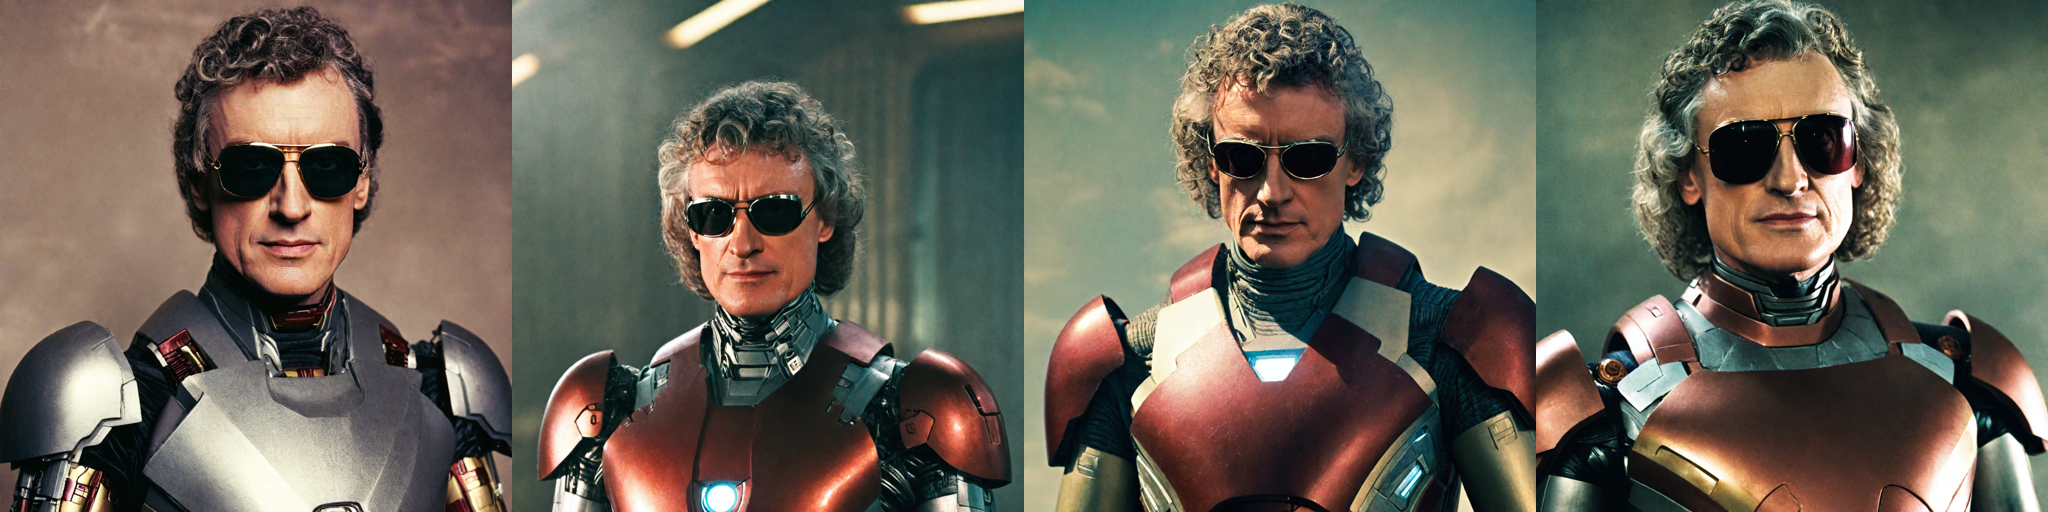

In [15]:
# Show and save the results
## Downsample for visualization
grid = image_grid(images, 1, 4, size_after_resize=512)

os.makedirs(save_path, exist_ok=True)
for idx, image in enumerate(images):
    image.save(os.path.join(save_path, f"photomaker_{idx:02d}.png"))

print("Results:")
grid
